In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Flatten, Dense, Dropout, Multiply, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tushare as ts
from sklearn.model_selection import train_test_split

In [2]:
ts.set_token('b425510f91120626ceacdcd9a36087804c9484b2555dd79beab964b2')
pro=ts.pro_api()
ticker='000002'
Vanke=ts.get_k_data(ticker,'2020-01-01','2024-10-01')
Vanke.set_index('date',inplace=True)
Vanke.index=pd.to_datetime(Vanke.index)
data=Vanke

# 选择所需的特征
features = ['open', 'close', 'high', 'low']

# 数据归一化
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 创建时间序列输入
def create_sequences(data, feature_columns, sequence_length=8):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[feature_columns].iloc[i:i+sequence_length].values
        label = data[feature_columns].iloc[i+sequence_length].values
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 使用前8天的数据预测第9天的open, close, high, low
sequence_length = 8
X, y = create_sequences(data, features, sequence_length)
# 分割数据集（80% 训练集, 20% 测试集）
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
# 定义 TemporalBlock 类
class TemporalBlock(layers.Layer):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.residual = layers.Conv1D(n_outputs, kernel_size=1)
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        res = self.residual(inputs)
        x = self.relu(self.conv1(inputs))
        x = self.conv2(x)
        x = self.dropout(x)
        x += res
        return x
    
class TCNModel(tf.keras.Model):
    def __init__(self, input_shape, num_channels=[64, 64, 64], kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()

        self.input_layer = layers.InputLayer(input_shape=input_shape)
        self.blocks = []

        # 构建 Temporal Blocks
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_shape[1] if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            self.blocks.append(TemporalBlock(n_inputs=in_channels, n_outputs=out_channels, kernel_size=kernel_size,
                                             stride=1, dilation=dilation_size, padding='causal', dropout=dropout))

        # 定义 Flatten 和 Dense 层
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(dropout)
        self.dense = layers.Dense(len(features), activation='linear')  # 输出与特征数一致

    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.dropout(x)
        output = self.dense(x)
        return output

In [4]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
model = TCNModel(input_shape)

# 编译模型
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 训练模型
history = model.fit(X_train, y_train, epochs=200, batch_size=64)


Epoch 1/200


D:\anaconda\conda\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1622 - mae: 0.2819
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mae: 0.0724
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0411
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mae: 0.0346
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0300
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0305
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mae: 0.0296
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0272
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0268
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0258
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0256
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mae: 0.0247
Epoch 13/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4700e-04 - mae: 0.0156
Epoch 71/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8451e-04 - mae: 0.0141
Epoch 72/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4028e-04 - mae: 0.0129
Epoch 73/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7690e-04 - mae: 0.0118
Epoch 74/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2181e-04 - mae: 0.0127
Epoch 75/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4232e-04 - mae: 0.0150
Epoch 76/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7985e-04 - mae: 0.0138
Epoch 77/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9821e-04 - mae: 0.0147
Epoch 78/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1944e-04 - mae: 0.0125
Epoch 79/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3284e-04 - mae: 0.0133
Epoch 80/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7529e-04 - mae: 0.0120
Epoch 81/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4156e-04 - mae: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4734e-04 - mae: 0.0112
Epoch 139/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0676e-04 - mae: 0.0123
Epoch 140/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1194e-04 - mae: 0.0124
Epoch 141/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3358e-04 - mae: 0.0131
Epoch 142/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9980e-04 - mae: 0.0121
Epoch 143/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0691e-04 - mae: 0.0130
Epoch 144/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3901e-04 - mae: 0.0134
Epoch 145/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5262e-04 - mae: 0.0112
Epoch 146/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1690e-04 - mae: 0.0129
Epoch 147/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6458e-04 - mae: 0.0117
Epoch 148/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0910e-04 - mae: 0.0121
Epoch 149/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9129e

In [5]:
# 模型预测
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Duplicate key in file WindowsPath('D:/anaconda/conda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 789 ('font.family         : sans-serif')
Duplicate key in file WindowsPath('D:/anaconda/conda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 790 ('font.sans-serif         : SimHei')
Duplicate key in file WindowsPath('D:/anaconda/conda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 791 ('axes.unicode_minus  : False')


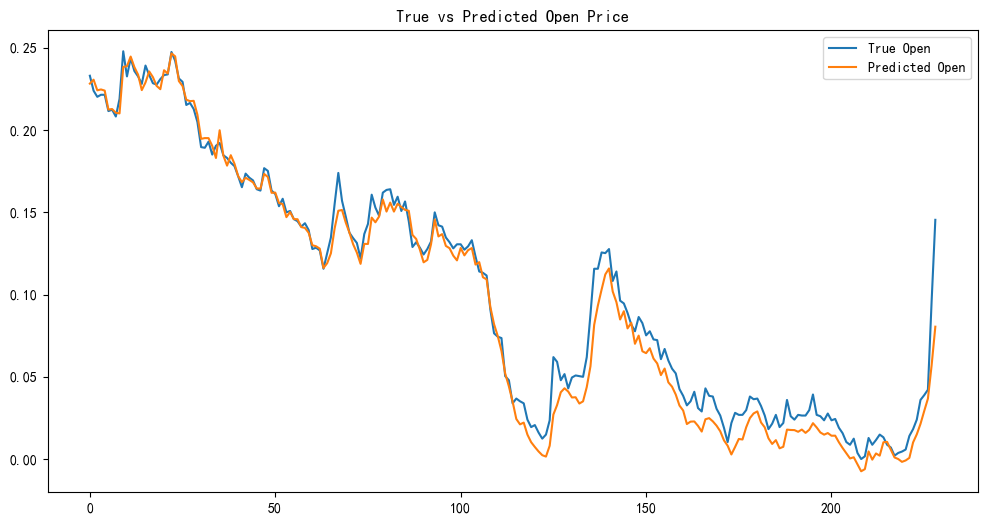

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True Open')
plt.plot(y_pred[:, 0], label='Predicted Open')
plt.title('True vs Predicted Open Price')
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 计算MAE、RMSE、MAPE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 计算绝对误差和误差分布
absolute_errors = np.abs(y_test - y_pred)
mean_absolute_error_by_feature = np.mean(absolute_errors, axis=0)

# 打印每个特征的平均绝对误差
features = ['Open', 'Close', 'High', 'Low']  # 对应的特征列
for i, feature in enumerate(features):
    print(f"Mean Absolute Error for {feature}: {mean_absolute_error_by_feature[i]:.4f}")

Mean Absolute Error (MAE): 0.0161
Root Mean Squared Error (RMSE): 0.0243
Mean Absolute Error for Open: 0.0081
Mean Absolute Error for Close: 0.0096
Mean Absolute Error for High: 0.0351
Mean Absolute Error for Low: 0.0117


C:\Users\jc\AppData\Local\Temp\ipykernel_24416\3999406571.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [8]:
start_date = '2024-01-01'
end_date = '2024-10-01'

# 使用日期范围截取数据
data_filtered = data.loc[start_date:end_date]

# 查看截取后的数据
print(data_filtered.shape)

(181, 6)


In [9]:
import numpy as np
import pandas as pd

sequence_length = 8

# Step 1: 创建输入序列
def create_sequences(data, feature_columns, sequence_length=8):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[feature_columns].iloc[i:i+sequence_length].values
        label = data[feature_columns].iloc[i+sequence_length].values
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 归一化处理
scaler = MinMaxScaler()
data_filtered[['open', 'close', 'high', 'low']] = scaler.fit_transform(data_filtered[['open', 'close', 'high', 'low']])

# Step 2: 生成输入数据（用过去8天的数据预测）
X_filtered, _ = create_sequences(data_filtered, ['open', 'close', 'high', 'low'], sequence_length)

# Step 3: 使用训练好的模型进行预测
predicted_values = model.predict(X_filtered)
print(predicted_values.shape)

C:\Users\jc\AppData\Local\Temp\ipykernel_24416\4217725219.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[['open', 'close', 'high', 'low']] = scaler.fit_transform(data_filtered[['open', 'close', 'high', 'low']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
(173, 4)


In [10]:
# 计算RSI值
def calculate_rsi(data, window=14):
    # 计算价格差
    delta = data.diff()
    
    # 计算上涨和下跌部分
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # 计算平均上涨和平均下跌
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    # 计算相对强弱（RS）
    rs = avg_gain / avg_loss
    
    # 计算RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi


# 创建一个DataFrame用于存储预测结果
predicted_df = pd.DataFrame(predicted_values, columns=['open', 'close', 'high', 'low'])
predicted_df['date'] = data_filtered.index[sequence_length:]  # 添加日期列，和原数据对齐

# 计算预测的收盘价的RSI值
predicted_df['RSI'] = calculate_rsi(predicted_df['close'], window=14)
predicted_df = predicted_df[predicted_df['RSI'] != 0]
predicted_df = predicted_df.dropna(subset=['RSI'])

# 打印计算出的RSI
print(predicted_df)

         open     close      high       low       date        RSI
5    0.775577  0.785448  0.759980  0.781038 2024-01-19   4.475622
6    0.782088  0.793342  0.761891  0.781251 2024-01-22  11.108443
7    0.698987  0.705865  0.675351  0.697972 2024-01-23   6.277674
8    0.721271  0.742803  0.711181  0.726602 2024-01-24  20.817952
9    0.780788  0.786320  0.764287  0.777027 2024-01-25  33.053996
..        ...       ...       ...       ...        ...        ...
168  0.145716  0.151981  0.216853  0.146875 2024-09-24  63.473190
169  0.185823  0.188367  0.226692  0.175983 2024-09-25  71.830293
170  0.245210  0.261598  0.279650  0.221983 2024-09-26  79.113515
171  0.385794  0.391536  0.430762  0.354425 2024-09-27  85.624771
172  0.548286  0.527755  0.533766  0.538567 2024-09-30  87.997005

[168 rows x 6 columns]


MA窗口=5天，夏普年化因子=18.33
总收益: 136.60%
夏普比率: 2.55
最大回撤: -30.01%
胜率: 100.00%


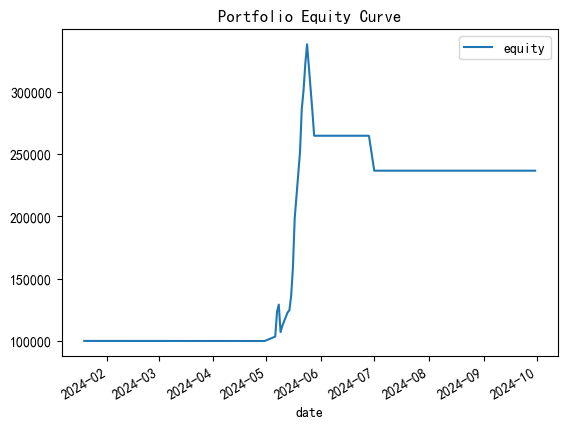

In [11]:
import pandas as pd
import numpy as np

# ========================
# 第一部分：参数自适应调整（基于数据长度）
# ========================

def auto_adjust_parameters(data_length):
    """根据数据长度自动调整关键参数"""
    params = {}
    
    params['ma_window'] = 5 
    
    params['sharpe_annual_factor'] = np.sqrt(data_length * 2)  
    return params

# ========================
# 第二部分：交易信号生成（自适应MA窗口）
# ========================

def generate_signals(df, params):
    """
    输入数据列：date, close, RSI
    输出信号列：signal (1=买入, -1=卖出)
    """
    # 计算动态移动平均
    df['MA'] = df['close'].rolling(params['ma_window']).mean()
    
    # 生成信号（示例逻辑：RSI<30且价格高于MA时买入）
    df['signal'] = 0
    buy_condition = (df['RSI'] < 30) & (df['close'] > df['MA'])
    sell_condition = (df['RSI'] > 70) & (df['close'] < df['MA'])
    
    df.loc[buy_condition, 'signal'] = 1
    df.loc[sell_condition, 'signal'] = -1
    
    # 避免未来数据：信号延后一期执行
    df['exec_signal'] = df['signal'].shift(1)
    return df

# ========================
# 第三部分：回测引擎（支持短期数据）
# ========================
def backtest(df, initial_capital=100000, commission=0.0005, stop_loss=0.03):
    """回测函数，考虑每一步的损失（止损3%）"""
    capital = initial_capital
    position = 0
    equity = []
    entry_price = 0  # 记录进场价格
    
    for i in range(len(df)):
        current = df.iloc[i]
        
        # 买入逻辑
        if current['exec_signal'] == 1 and position == 0:
            # 全仓买入（可优化为风险比例仓位）
            position = capital / current['close']
            capital = 0
            # 扣除手续费
            position *= (1 - commission)
            
            # 记录进场价格
            entry_price = current['close']
        
        # 卖出逻辑
        elif current['exec_signal'] == -1 and position > 0:
            capital = position * current['close']
            position = 0
            # 扣除手续费
            capital *= (1 - commission)
        
        # 止损逻辑（当亏损达到3%时止损）
        if position > 0 and (current['close'] / entry_price - 1) <= -stop_loss:
            capital = position * current['close']  # 卖出
            position = 0
            # 扣除手续费
            capital *= (1 - commission)
        
        # 计算当前权益
        equity.append(capital + position * current['close'])
    
    df['equity'] = equity
    return df

# ========================
# 第四部分：绩效评估（短期数据友好）
# ========================

def evaluate_performance(df, params):
    """计算适应短期数据的绩效指标"""
    returns = df['equity'].pct_change().dropna()
    
    # 夏普比率（使用动态年化因子）
    sharpe = returns.mean() / returns.std() * params['sharpe_annual_factor']
    
    # 最大回撤（基于权益曲线）
    peak = df['equity'].cummax()
    drawdown = (df['equity'] - peak) / peak
    max_dd = drawdown.min()
    
    # 胜率计算
    trade_returns = []
    in_trade = False
    entry_price = 0
    for i in range(len(df)):
        if df.iloc[i]['exec_signal'] == 1 and not in_trade:
            entry_price = df.iloc[i]['close']
            in_trade = True
        elif df.iloc[i]['exec_signal'] == -1 and in_trade:
            exit_price = df.iloc[i]['close']
            trade_return = (exit_price / entry_price - 1)
            trade_returns.append(trade_return)
            in_trade = False
    
    win_rate = len([r for r in trade_returns if r > 0]) / len(trade_returns) if trade_returns else 0
    
    return {
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate,
        'Total Return': df['equity'].iloc[-1] / initial_capital - 1
    }

if __name__ == "__main__":
    df = predicted_df
    initial_capital = 100000
    
    # 步骤1：自动参数调整
    params = auto_adjust_parameters(len(df))
    print(f"MA窗口={params['ma_window']}天，夏普年化因子={params['sharpe_annual_factor']:.2f}")
    
    # 步骤2：生成交易信号
    df = generate_signals(df, params)
    
    # 步骤3：运行回测
    df = backtest(df, initial_capital)
    
    # 步骤4：评估绩效
    metrics = evaluate_performance(df, params)
    print(f"总收益: {metrics['Total Return']:.2%}")
    print(f"夏普比率: {metrics['Sharpe']:.2f}")
    print(f"最大回撤: {metrics['Max Drawdown']:.2%}")
    print(f"胜率: {metrics['Win Rate']:.2%}")
    
    # 可视化权益曲线
    df.plot(x='date', y='equity', title='Portfolio Equity Curve')